# **Clasificación de noticias empleando una LSTM con atención**

El objetivo es emplear una LSTM con un mecanismo de atención para poder clasificar noticias de dos categorías similares. El dataset se obtuvo de [Kaggle](https://www.kaggle.com/datasets/rmisra/news-category-dataset).

## Importar las librerías

In [1]:
import re
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Layer, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


## Cargar los datos

In [2]:
def load_data(filename, num_samples=20000):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_samples:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [3]:
df = load_data('News_Category_Dataset_v3.json', 20000)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
19995,https://www.huffingtonpost.com/entry/mugabe-cl...,Zimbabwe's Mugabe Clings To Power As His Resig...,WORLD NEWS,He and his wife Grace would be granted full im...,"Joe Brock and MacDonald Dzirutwe, Reuters",2017-11-20
19996,https://www.huffingtonpost.com/entry/transitio...,Transition In The Middle East: Transition To W...,WORLD NEWS,Transition is the name of the game in the Midd...,"James M. Dorsey, ContributorS. Rajaratnam Scho...",2017-11-20
19997,https://www.huffingtonpost.com/entry/germany-c...,What You Need To Know About 'Germany's Brexit ...,WORLD NEWS,The breakdown of coalition talks has plunged G...,"Marco Fieber, HuffPost Germany",2017-11-20
19998,https://www.huffingtonpost.com/entry/new-york-...,New York City’s Subways Need Congestion Pricin...,POLITICS,"In a major, thorough and truly important piece...","Steven Cohen, ContributorProfessor in the Prac...",2017-11-20


## Filtrar las clases

In [4]:
print("Número de clases:", df['category'].nunique())

Número de clases: 36


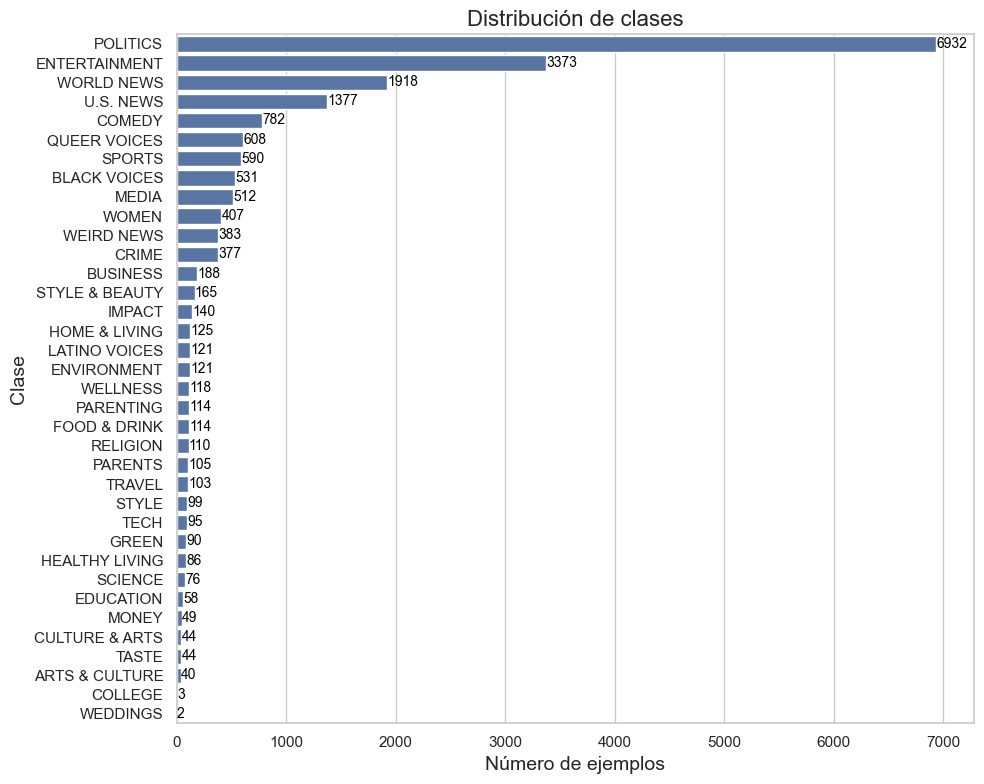

In [5]:
# Obtener la distribución de clases
class_distribution = df['category'].value_counts()

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
ax = sns.barplot(x=class_distribution.values, y=class_distribution.index)
plt.title('Distribución de clases', fontsize=16)
plt.xlabel('Número de ejemplos', fontsize=14)
plt.ylabel('Clase', fontsize=14)

# Añadir los valores en las barras
for i, v in enumerate(class_distribution.values):
    ax.text(v + 3, i, str(v), color='black', fontsize=10, ha='left', va='center')

plt.tight_layout()
plt.show()

In [6]:
# Filtrar el df para mantener solo world news y U.S. news
categories_to_keep = ['WORLD NEWS', 'U.S. NEWS']
df_filtered = df[df['category'].isin(categories_to_keep)].copy()

## Balancear las clases

In [7]:
# Obtener conteos por clase
class_counts = df_filtered['category'].value_counts()
print("Conteo original por clase:")
print(class_counts)

# Iigualar al número de ejemplos de la clase minoritaria
minority_class_count = class_counts.min()

df_balanced = pd.concat([
    df_filtered[df_filtered['category'] == 'U.S. NEWS'],
    df_filtered[df_filtered['category'] == 'WORLD NEWS'].sample(n=minority_class_count, random_state=42)
])

# Verificar el balanceo
print("\nConteo después de downsampling:")
print(df_balanced['category'].value_counts())

Conteo original por clase:
category
WORLD NEWS    1918
U.S. NEWS     1377
Name: count, dtype: int64

Conteo después de downsampling:
category
U.S. NEWS     1377
WORLD NEWS    1377
Name: count, dtype: int64


## Visualización de las noticias por categoría

In [8]:
# Mostrar ejemplos aleatorios de cada categoría
def show_sample_news(category, num_samples=3):
    print(f"=== Ejemplos de {category} ===")
    sample_news = df_filtered[df_filtered['category'] == category].sample(num_samples, random_state=42)
    for idx, row in sample_news.iterrows():
        print(f"\nFecha: {row['date']}")
        print(f"Título: {row['headline']}")
        print(f"Autor(es): {row['authors']}")
        print(f"Descripción: {row['short_description']}")
        print(f"Enlace: {row['link']}")
        print("-" * 80)

In [9]:
show_sample_news('U.S. NEWS')

=== Ejemplos de U.S. NEWS ===

Fecha: 2020-10-24
Título: Couple Married For 68 Years Dies In Colorado Wildfire After Refusing To Leave Home
Autor(es): Sara Boboltz
Descripción: A relative said they were found in each other's arms.
Enlace: https://www.huffpost.com/entry/colorado-couple-dies-home-fire_n_5f944d39c5b6e7772655d40c
--------------------------------------------------------------------------------

Fecha: 2021-02-05
Título: Volunteer Army Helps Florida Elders Book Coveted COVID-19 Shots
Autor(es): ADRIANA GOMEZ LICON, Associated Press
Descripción: Volunteers are helping older people clear the daunting hurdles of state-run registration systems that are poorly organized and rely heavily on technology.
Enlace: https://www.huffpost.com/entry/volunteer-army-helps-florida-elders-book-coveted-covid-19-shots_n_601d227ec5b66c385ef88459
--------------------------------------------------------------------------------

Fecha: 2020-02-07
Título: Frustration In Colorado City As Cop Found Dru

In [10]:
show_sample_news('WORLD NEWS')

=== Ejemplos de WORLD NEWS ===

Fecha: 2018-08-24
Título: Trump Calls Off Pompeo's North Korea Trip
Autor(es): Saba Hamedy
Descripción: In tweets posted Friday, the president didn’t rule out future talks.
Enlace: https://www.huffpost.com/entry/trump-north-korea-pompeo-talks_n_5b8044d6e4b072951512ad17
--------------------------------------------------------------------------------

Fecha: 2018-02-15
Título: Zuma Resigns: South Africa Loses Its Innocence
Autor(es): Pieter du Toit, Editor-in-Chief, HuffPost South Africa
Descripción: The South African president's departure marks the end of a term beset by corruption and poor governance.
Enlace: https://www.huffingtonpost.com/entry/jacob-zuma-south-africa-resign_us_5a84eec4e4b0058d5565cbbf
--------------------------------------------------------------------------------

Fecha: 2019-09-02
Título: Record-Setting Hurricane Dorian Batters Northern Bahamas, Leaves Trail Of Destruction
Autor(es): Ramón Espinosa, AP
Descripción: On Sunday, Dorian 

In [11]:
# Visualización gráfica de los textos más comunes
def plot_wordcloud_by_category(category):
    text = ' '.join(df_filtered[df_filtered['category'] == category]['headline'] + " " + 
                    df_filtered[df_filtered['category'] == category]['short_description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Palabras más frecuentes en {category}', size=21)
    plt.axis('off')
    plt.show()

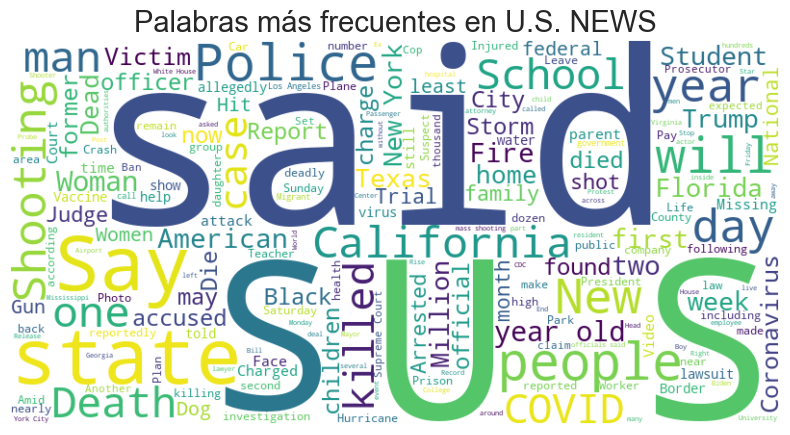

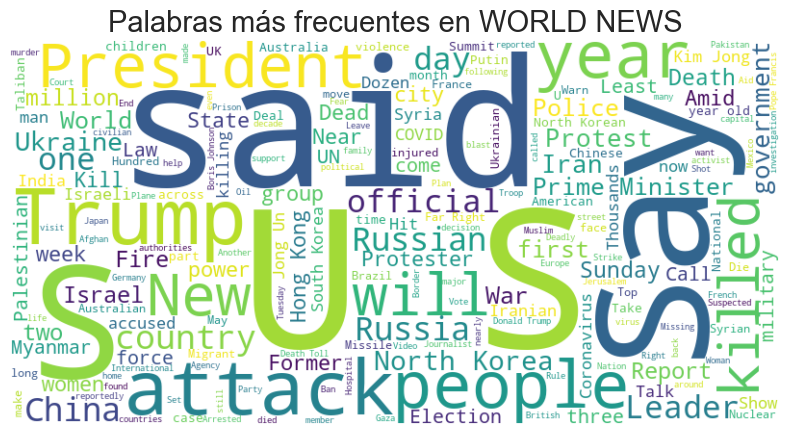

In [12]:
plot_wordcloud_by_category('U.S. NEWS')
plot_wordcloud_by_category('WORLD NEWS')

In [13]:
# Longitud de textos
df_filtered['text_length'] = df_filtered['headline'].str.len() + df_filtered['short_description'].str.len()

In [14]:
def mostrar_noticias_extremas(categoria, mostrar_top=1, mostrar_short=1):
    df_categoria = df_filtered[df_filtered['category'] == categoria] # Filtrar por categoría

    print(f"----- Noticia más larga en {categoria} -----")
    longest_news = df_categoria.nlargest(mostrar_top, 'text_length')
    for idx, row in longest_news.iterrows():
        print(f"Título: {row['headline']}")
        print(f"Descripción: {row['short_description']}")
        print(f"Longitud: {row['text_length']} caracteres")
        print(f"Enlace: {row['link']}")
    
    print(f"\n----- Noticia más corta en {categoria} -----")
    shortest_news = df_categoria.nsmallest(mostrar_short, 'text_length')
    for idx, row in shortest_news.iterrows():
        print(f"Título: {row['headline']}")
        print(f"Descripción: {row['short_description']}")
        print(f"Longitud: {row['text_length']} caracteres")
        print(f"Enlace: {row['link']}")

In [15]:
mostrar_noticias_extremas('U.S. NEWS')

----- Noticia más larga en U.S. NEWS -----
Título: Settlement Between Jeffrey Epstein And Prince Andrew Accuser Now Public
Descripción: The deal between Epstein and Virginia Roberts, now known as Virginia Giuffre, contained a paragraph that said it protects anyone “who could have been included as a potential defendant” from lawsuits filed by Giuffre.
Longitud: 287 caracteres
Enlace: https://www.huffpost.com/entry/jeffrey-epstein-prince-andrew-accuser-settlement_n_61d339d2e4b0bb04a63b9bed

----- Noticia más corta en U.S. NEWS -----
Título: Parkland Survivor David Hogg's Home 'Swatted'
Descripción: No one was home at the time.
Longitud: 73 caracteres
Enlace: https://www.huffpost.com/entry/david-hogg-house-swatted-parkland_n_5b16a31ae4b074b9e08a0a2e


In [16]:
mostrar_noticias_extremas('WORLD NEWS')

----- Noticia más larga en WORLD NEWS -----
Título: WHO Raises Alarm On Disease In Flood-hit Areas Of Pakistan
Descripción: The World Health Organization is raising the alarm about a “second disaster” in the wake of the deadly floods in Pakistan this summer, as doctors and medical workers on the ground race to battle outbreaks of waterborne and other diseases.
Longitud: 296 caracteres
Enlace: https://www.huffpost.com/entry/bc-as-pakistan-floods_n_63260f56e4b027aa4066b0f6

----- Noticia más corta en WORLD NEWS -----
Título: Same-Sex Weddings Begin In Australia
Descripción: Congrats to all!
Longitud: 52 caracteres
Enlace: https://www.huffingtonpost.com/entry/same-sex-weddings-australia_us_5a378bd7e4b040881bec0362


## Preprocesamiento

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Eliminar caracteres especiales y números
    
    words = text.split() # Dividir la cadena de texto en una lista de palabras
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Eliminar stopwords y lematizar

    return ' '.join(words)

In [18]:
# Aplicar limpieza a los textos (títulos y descripciones)
df_balanced['clean_headline'] = df_balanced['headline'].apply(clean_text)
df_balanced['clean_description'] = df_balanced['short_description'].apply(clean_text)

# Combinar headline y description para el modelo
df_balanced['combined_text'] = df_balanced['clean_headline'] + ' ' + df_balanced['clean_description']

## Preparación de los datos para el modelo

In [19]:
# Codificación de las categorías
label_encoder = LabelEncoder()
df_balanced['category_encoded'] = label_encoder.fit_transform(df_balanced['category'])

# Verificar el mapeo de categorías a números
print("\nMapeo de categorías a códigos numéricos:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")


Mapeo de categorías a códigos numéricos:
U.S. NEWS: 0
WORLD NEWS: 1


In [20]:
max_words = 500 # Número máximo de palabras a considerar
max_len = 200 # Longitud máxima de las secuencias (número de palabras por ejemplo)

# Tokenizar el texto (convertir las palabras en índices numéricos)
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['combined_text']) # Ajustar el tokenizador al texto
sequences = tokenizer.texts_to_sequences(df_balanced['combined_text']) # Convertir los textos en secuencias de enteros
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post') # Rellenar o truncar las secuencias para que todas tengan la misma longitud

In [21]:
# Convierte los valores numéricos de clase en vectores one-hot
y = to_categorical(df_balanced['category_encoded'])
num_classes = y.shape[1]

In [22]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2203, 200)
Shape of y_train: (2203, 2)

Shape of X_test: (551, 200)
Shape of y_test: (551, 2)


In [23]:
print("Distribución en train:")
print(pd.DataFrame(y_train).sum())

print("\nDistribución en test:")
print(pd.DataFrame(y_test).sum())

Distribución en train:
0    1103.0
1    1100.0
dtype: float64

Distribución en test:
0    274.0
1    277.0
dtype: float64


## Definición del mecanismo de atención

In [24]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform") # Matriz de transformación para los estados ocultos (d x d)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros") # Vector de bias para cada paso de tiempo (T x 1)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1], 1), initializer="glorot_uniform") # Vector de contexto para calcular la importancia (d x 1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calcula puntuaciones de atención
        et = K.tanh(K.dot(x, self.W) + self.b) # Transformación no lineal de los estados ocultos
        et = K.dot(et, self.u) # Calcula puntuaciones de atención (energías)

        # Aplica softmax para obtener pesos de atención
        at = K.softmax(K.squeeze(et, axis=-1))
        at = K.expand_dims(at, axis=-1)
        
        # Aplica los pesos a la entrada original
        output = x * at # Aplica atención
        
        return K.sum(output, axis=1) # Suma ponderada

    def compute_output_shape(self, input_shape):
        # Especifica la forma de salida de la capa
        return (input_shape[0], input_shape[-1])

## Contrucción del modelo LSTM con atención

In [25]:
def build_model(vocab_size, embedding_dim, max_len):
    inputs = Input(shape=(max_len,))
    
    # Capa de embedding (transforma los índices de palabras (enteros) en vectores densos)
    embedding_layer = Embedding(input_dim=vocab_size, 
                                output_dim=embedding_dim, 
                                input_length=max_len,
                                mask_zero=True, # Para ignorar padding
                                embeddings_regularizer=l2(0.001))(inputs)
    embedding_layer = Dropout(0.5)(embedding_layer)
    
    # Capa LSTM bidireccional
    # Devuelve una salida por cada palabra (necesaria para la atención)
    lstm_out = Bidirectional(LSTM(units=128, 
                                  return_sequences=True, 
                                  dropout=0.5, 
                                  recurrent_dropout=0.5,
                                  kernel_regularizer=l2(0.001)))(embedding_layer)
    
    # Mecanismo de atención
    # Calcula pesos de atención y devuelve una suma ponderada, que representa la parte más relevante del texto para la clasificación
    attention_output = AttentionLayer()(lstm_out)
    
    # Capas densas
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(attention_output)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    outputs = Dense(1, activation='sigmoid')(dropout2)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [26]:
# Parámetros del modelo
vocab_size = min(max_words, len(tokenizer.word_index)) + 1 # Tamaño del vocabulario basado en el tokenizador.
embedding_dim = 128 # Dimensión de los vectores que representan palabras

# Construir y compilar el modelo
model = build_model(vocab_size, embedding_dim, max_len)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\yamil\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\yamil\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │     64,128 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    263,168 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │     65,992 │ bidirectional[0]… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 411,849 (1.57 MB)

 Trainable params: 411,849 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [27]:
# Ajustar las etiquetas para clasificación binaria
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

history = model.fit(X_train, y_train_binary, validation_data=(X_test, y_test_binary), epochs=25)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5226 - loss: 1.0833 - val_accuracy: 0.4973 - val_loss: 0.7570
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5179 - loss: 0.7356 - val_accuracy: 0.5027 - val_loss: 0.7114
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5172 - loss: 0.7081 - val_accuracy: 0.6425 - val_loss: 0.6695
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6749 - loss: 0.6653 - val_accuracy: 0.7550 - val_loss: 0.6162
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 946ms/step - accuracy: 0.7892 - loss: 0.5943 - val_accuracy: 0.7804 - val_loss: 0.5355
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 858ms/step - accuracy: 0.7830 - loss: 0.5502 - val_accuracy: 0.8004 - val_loss: 0.5049
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8284 - loss: 0.4788 - val_accuracy: 0.7877 - val_loss: 0.5137
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 860ms/step - accuracy: 0.8626 - loss: 0.4323 - val_accuracy: 0.7985 -

## Evaluación del modelo

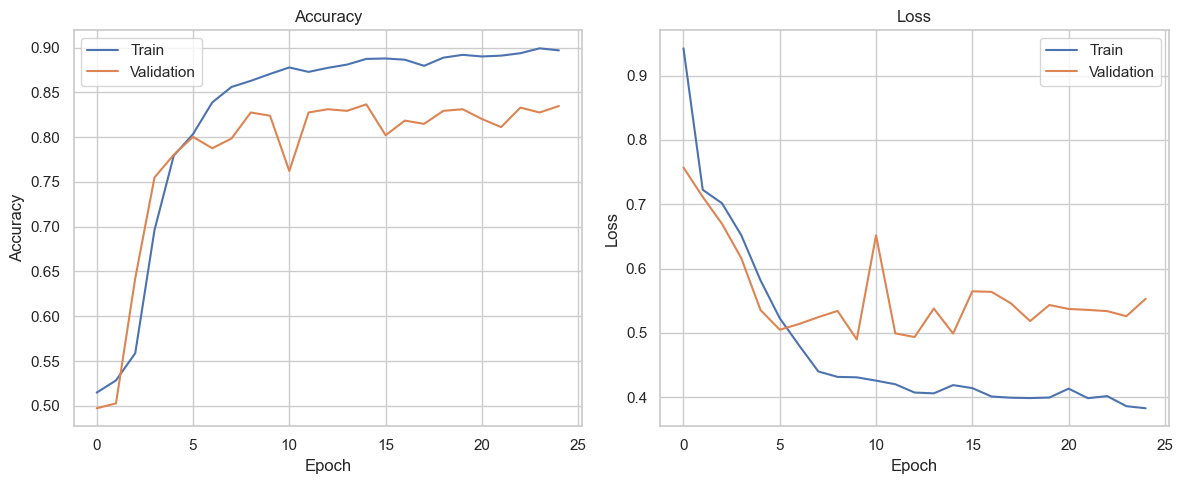

In [ ]:
# Curvas de accuracy y loss durante el entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Función para evaluar el rendimiento del modelo, se obtiene el accuracy y la matriz de confusión
def evaluate_model(X, y, model, set_name='Test'):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    acc = accuracy_score(y, y_pred)
    print(f'\n{set_name} accuracy: {acc:.4f}')
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{set_name} confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

c:\Users\yamil\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\layer.py:938: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step

Train accuracy: 0.9324


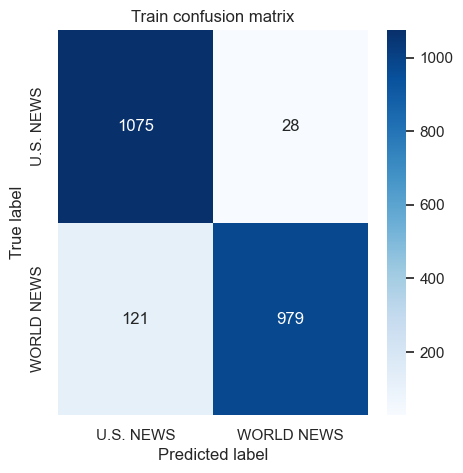

In [30]:
evaluate_model(X_train, y_train_binary, model, 'Train')

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step

Test accuracy: 0.8348


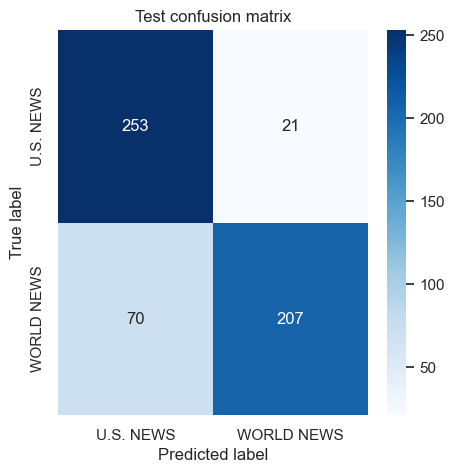

In [31]:
evaluate_model(X_test, y_test_binary, model, 'Test')

## Ejemplos de noticias mal clasificadas

In [ ]:
def misclassified_examples(X, y, df, model, n=5, set_name='test'):
    y_pred_probs = model.predict(X)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    incorrect_indices = np.where(y != y_pred.flatten())[0]
    
    print(f'\nEjemplos de noticias mal clasificadas en {set_name}:')
    for idx in incorrect_indices[:n]:  # Mostrar hasta n ejemplos
        print(f'\nTítulo: {df.iloc[idx]["headline"]}')
        print(f'Descripción: {df.iloc[idx]["short_description"]}')
        print(f'Categoría real: {label_encoder.classes_[y[idx]]}')
        print(f'Predicción: {label_encoder.classes_[y_pred[idx][0]]}')

In [38]:
misclassified_examples(X_test, y_test_binary, df_balanced, model, n=5, set_name='test')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Ejemplos de noticias mal clasificadas en test:

Título: U.S. Inflation Falls For 2nd Straight Month On Lower Gas Costs
Descripción: On a monthly basis, prices rose 0.1%, after a flat reading in July.
Categoría real: U.S. NEWS
Predicción: WORLD NEWS

Título: Payment Processor Visa To Start Categorizing Sales At Gun Stores
Descripción: Visa’s adoption is significant as the largest payment network, and will likely add pressure for Mastercard and American Express to adopt the code as well.
Categoría real: WORLD NEWS
Predicción: U.S. NEWS

Título: Mississippi Governor Says Water Pressure Is Now 'Solid' In Jackson
Descripción: The city remains under a boil water notice, which first went into effect on July 30.
Categoría real: WORLD NEWS
Predicción: U.S. NEWS

Título: School Starts Today For Survivors Of Deadly Mass Shooting In Uvalde
Descripción: There is new high fencing around the Texas community's public schools that still isn't finished and a heavy

In [39]:
misclassified_examples(X_train, y_train_binary, df_balanced, model, n=5, set_name='train')

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step
Ejemplos de noticias mal clasificadas en train:

Título: Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police
Descripción: The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found dead Monday after her family reported her missing, authorities said.
Categoría real: WORLD NEWS
Predicción: U.S. NEWS

Título: One Dead After Plane Crashes At Reno Air Race
Descripción: The single-engine plane was participating in the National Championship Air Races on Sunday when it crashed into a field, killing the pilot, officials said.
Categoría real: WORLD NEWS
Predicción: U.S. NEWS

Título: Family Of American Held In Afghanistan Says He Was Freed By Taliban In Prisoner Swap
Descripción: Mark Frerichs, a Navy veteran and civilian contractor, was kidnapped in Afghanistan in January 2020.
Categoría real: WORLD NEWS
Predicción: U.S. NEWS

Título: Plane That Circled Mississippi Threatening To Crash Has Landed
Descr

## Visualizar la atención en las noticias

In [49]:
def get_attention_weights(model, X_sample):
    """
    Obtiene los pesos de atención de la capa de atención de un modelo.
    
    Parámetros:
    - model: Modelo entrenado con una capa de atención.
    - X_sample: Un lote de secuencias tokenizadas de entrada.
    
    Retorna:
    - atenciones: Matriz de pesos de atención.
    - predicciones: Salidas del modelo.
    """
    attention_layer = None
    for layer in model.layers:
        if 'attention' in layer.name.lower():
            attention_layer = layer
            break

    attention_model = tf.keras.Model(inputs=model.input, outputs=[attention_layer.output, model.output])
    attention_weights, predictions = attention_model.predict(X_sample)
    
    return attention_weights, predictions

def visualize_attention(sentence, tokenizer, model, max_length=200):
    """
    Visualiza las palabras de la noticia resaltando las que recibieron más atención.
    
    Parámetros:
    - sentence: Texto de la noticia.
    - tokenizer: Tokenizer usado para la tokenización.
    - model: Modelo entrenado con una capa de atención.
    - max_length: Longitud máxima de las secuencias en el modelo.
    """
    # Tokenizar la oración
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Obtener pesos de atención
    attention_weights, _ = get_attention_weights(model, padded_sequence)
    attention_weights = attention_weights.squeeze()  # Eliminar dimensiones extra
    
    # Convertir tokens a palabras
    words = sentence.split()[:max_length]  # Ajustar a la longitud esperada
    attention_weights = attention_weights[:len(words)]  # Ajustar la longitud
    
    # Normalizar la atención para una mejor visualización
    attention_weights = attention_weights / np.max(attention_weights)
    
    # Crear el texto coloreado
    from IPython.core.display import display, HTML
    def colorize(word, weight):
        return f'<span style="background-color:rgba(100, 149, 237, {weight}); padding:2px 5px; border-radius:4px; color:white">{word}</span>'
    
    colored_text = " ".join([colorize(w, a) for w, a in zip(words, attention_weights)])
    display(HTML(f"<p>{colored_text}</p>"))


In [ ]:
sample_news = df_balanced.iloc[21]["headline"]
visualize_attention(sample_news, tokenizer, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


C:\Users\yamil\AppData\Local\Temp\ipykernel_18600\1941570796.py:50: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
